### Pedalcast: Predicting daily bike usage for each station - Modeling & Feature Engineering Notebook

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import shap
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [2]:
daily_counts = pd.read_csv('data/daily_counts_with_weather.csv')
daily_counts['date'] = pd.to_datetime(daily_counts['date'])

### Feature Engineering: `create_features(df)`

This function generates key features to support station-level bike demand forecasting. It takes a DataFrame with daily trip counts and returns a new DataFrame with additional time-based and lag features, including:

- **Calendar Features**:  
  `dayofweek`, `is_weekend`, `month`, `quarter`, `year`, `dayofyear`, `dayofmonth`, and `weekofyear`  
  These capture patterns related to the day, seasonality, and temporal cycles.

- **Season Label**:  
  A simplified `season` column is derived from the month and one-hot encoded.

- **Lag Features** (per station):  
  - `lag_1`: Trip count from the previous day  
  - `lag_7`: Trip count from the same day the previous week  
  - `rolling_7`: 7-day rolling average of trip count (excluding the current day)  

These features allow the model to learn from both recent usage trends and structured temporal patterns.

In [3]:
def create_features(df):
    out = df.copy()
    # Monday(0) - Sunday (6)
    out['dayofweek'] = out['date'].dt.dayofweek
    out['is_weekend'] = out['dayofweek'] >= 5
    out['quarter'] = out['date'].dt.quarter 
    out['year'] = out['date'].dt.year 
    out['month'] = out['date'].dt.month 
    out['dayofyear'] = out['date'].dt.dayofyear 
    out['dayofmonth'] = out['date'].dt.day 
    out['weekofyear'] = out['date'].dt.isocalendar().week 
   
    def assign_season(month):
        if month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Winter'

    out['season'] = out['month'].apply(assign_season)
    
    out = out.sort_values(['start_station_id', 'date'])

    out['lag_1'] = out.groupby('start_station_id')['trip_count'].shift(1)

    out['lag_7'] = out.groupby('start_station_id')['trip_count'].shift(7)
    
    out['rolling_7'] = (
        out.groupby('start_station_id')['trip_count']
           .shift(1)  # Exclude today
           .rolling(window=7)
           .mean()
           .reset_index(level=0, drop=True)
    )    
    return out

In [4]:
daily_counts_wft = create_features(daily_counts)
daily_counts_wft.head()

,start_station_id,start_station_name,date,trip_count,temp,humidity,precip,snow,windspeed,visibility,...,quarter,year,month,dayofyear,dayofmonth,weekofyear,season,lag_1,lag_7,rolling_7
0,A32000,Fan Pier,2023-07-01,30,19.3,93.5,0.000,0.0,20.3,4.8,...,3,2023,7,182,1,26,Summer,NaN,NaN,NaN
1,A32000,Fan Pier,2023-07-02,20,20.9,89.9,8.278,0.0,28.9,7.6,...,3,2023,7,183,2,26,Summer,30.0,NaN,NaN
2,A32000,Fan Pier,2023-07-03,28,20.4,89.4,14.249,0.0,18.0,10.4,...,3,2023,7,184,3,27,Summer,20.0,NaN,NaN
3,A32000,Fan Pier,2023-07-04,35,20.1,94.4,12.163,0.0,16.4,12.0,...,3,2023,7,185,4,27,Summer,28.0,NaN,NaN
4,A32000,Fan Pier,2023-07-05,41,23.9,78.4,0.000,0.0,17.8,13.3,...,3,2023,7,186,5,27,Summer,35.0,NaN,NaN


### Drop Rows with Missing Lag Features

Lag features like `lag_1`, `lag_7`, and `rolling_7` require prior data to be computed. As a result, the earliest days for each station (where lag values are undefined) contain missing values.
So, we drop them to ensure all training data has complete feature sets, which also preserves model quality by removing rows that lack historical context.

In [5]:
# drop some rows for lags
daily_counts_wft.isna().sum()[daily_counts_wft.isna().sum()!=0]

lag_1         554
lag_7        3877
rolling_7    3877
dtype: int64

In [6]:
# drop values with missing lags
daily_counts_wft = daily_counts_wft.dropna(subset=['lag_1', 'lag_7', 'rolling_7'])

#### Train/Test Split for Forecasting

We separate the dataset into features (`X`) and target (`y`), where `trip_count` is the value we want to predict.

Then, we split the data into:

- **Training data** includes all dates **before June 2025**
- **Test data** includes dates in **June 2025**, which we will use to evaluate model performance on unseen future data

Later, we’ll use **TimeSeriesSplit** for cross-validation on the training data during hyperparameter tuning, to ensure the model is validated on temporally consistent folds.

In [7]:
X = daily_counts_wft.drop(['trip_count'],axis=1,errors='ignore')
y = daily_counts_wft['trip_count']

X_train = X[X['date'] < '2025-06-01']
X_test = X[X['date'] >= '2025-06-01']
y_train = y.loc[X_train.index]
y_test = y.loc[X_test.index]

We drop columns `start_station_name` and `date` since they are non-numeric and redundant (already encoded). We needed them before to do certain operations like in the previous cell.

In [8]:
drop_cols = ['start_station_name', 'date']
X_train = X_train.drop(columns=drop_cols, errors='ignore')
X_test = X_test.drop(columns=drop_cols, errors='ignore')

#### One Hot Encode Station IDs and Season - Nominal Qualitative Columns

Since `start_station_id` and `season` is a string, we use `LabelEncoder` to convert it into a numeric format suitable for XGBoost.

#### Modeling Pipeline with One-Hot Encoding and XGBoost

We define a scikit-learn `Pipeline` that performs both preprocessing and model training in a single, reusable workflow:

- **`ColumnTransformer` with `OneHotEncoder`**:
  - Applies one-hot encoding to the categorical columns `start_station_id` and `season`

- **`XGBRegressor`**:
  - A tree-based regression model from the XGBoost library
  - Trained on the encoded and passed-through features

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(
        handle_unknown='ignore', drop='first'), ['start_station_id','season'])
    ],
    remainder='passthrough'  
)

xgb_pipeline = Pipeline(steps=[
    ('encoder', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

#### Hyperparameter Tuning with GridSearchCV

We perform a grid search over a predefined set of XGBoost hyperparameters to find the combination that minimizes RMSE.

- **Parameters tuned**: `max_depth`, `learning_rate`, `n_estimators`, `subsample`, and `colsample_bytree`
- **Cross-validation**: `TimeSeriesSplit` ensures temporally consistent folds
- **Scoring**: Negative RMSE is used as the optimization metric

The best model configuration is selected based on cross-validated RMSE.

**Note**: Other parameter combinations were also tested, but this setup consistently produced the best performance.

In [10]:
param_grid = {
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.05, 0.1],
    "model__n_estimators": [100, 300],
    "model__subsample": [0.8],
    "model__colsample_bytree": [0.8],
}

tscv = TimeSeriesSplit(n_splits=5)

xgb_grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # for RMSE
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)

print(f"Best RMSE: {-xgb_grid_search.best_score_:.2f}")
print("Best params:", xgb_grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.6s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   0.8s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   0.9s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   1.2s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.2s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   1.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.2s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=100, model__subsample=0.8; total time=   2.0s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.0s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   2.5s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   1.7s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   1.7s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.1s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   3.4s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=100, model__subsample=0.8; total time=   2.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   1.2s


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=5, model__n_estimators=300, model__subsample=0.8; total time=   2.6s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=3, model__n_estimators=300, model__subsample=0.8; total time=   4.4s
[CV] END model__colsample_bytree=0.8, model__learning_rate=0.05, model__max_depth=7, model__n_estimators=100, model__subsample=0.8; total time=   1.8s


#### Final Model Evaluation on Test Set

We use the best model from `GridSearchCV` to predict bike demand on the June 2025 test set.

- **RMSE (Root Mean Squared Error)** measures the average prediction error in trip counts.
- **R² Score** indicates how much variance in the target is explained by the model.

These metrics give a final assessment of how well the model generalizes to unseen future data.

In [359]:
y_pred = xgb_grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Test RMSE: 9.29
R² Score: 0.9223


/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/turkialrasheed/miniforge3/envs/dsc80/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [345]:
xgb_grid_search.best_params_

{'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.05,
 'model__max_depth': 7,
 'model__n_estimators': 300,
 'model__subsample': 0.8}

This indicates strong predictive performance.

#### Most Important Features for the Model

We use two methods to evaluate feature importance:

1. **XGBoost’s Built-in Feature Importances**  
   - `feature_importances_` returns the relative importance of each feature based on how much it contributes to reducing error (gain) across all trees.
   - A horizontal bar plot visualizes which features the model relied on most globally.

2. **SHAP (SHapley Additive exPlanations)**  
   - `TreeExplainer` is used to calculate SHAP values for each feature and each prediction.
   - The SHAP summary plot (`dot` plot) shows both the **magnitude** and **direction** of each feature’s impact across the dataset.

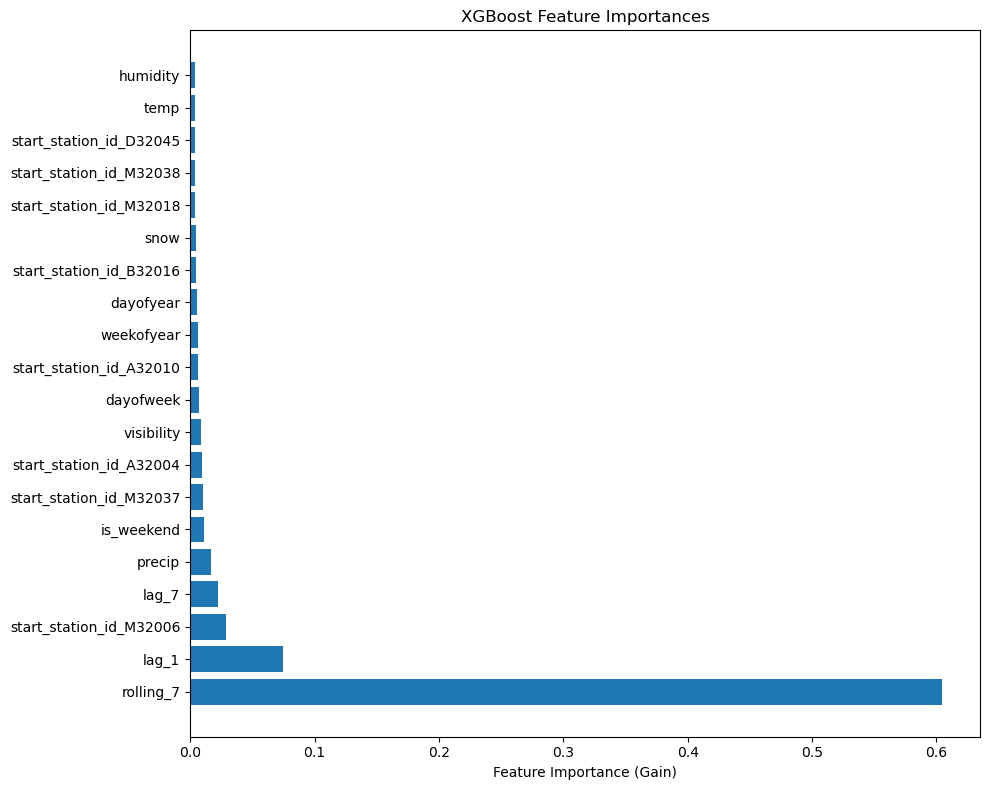

                     feature  importance
564                rolling_7    0.604740
562                    lag_1    0.074969
351  start_station_id_M32006    0.028661
563                    lag_7    0.022441
550                   precip    0.016386
555               is_weekend    0.011391
378  start_station_id_M32037    0.010647
3    start_station_id_A32004    0.009303
553               visibility    0.008873
554                dayofweek    0.007228
8    start_station_id_A32010    0.006408
561               weekofyear    0.006151
559                dayofyear    0.005376
71   start_station_id_B32016    0.004865
551                     snow    0.004307
360  start_station_id_M32018    0.004236
379  start_station_id_M32038    0.004194
258  start_station_id_D32045    0.004147
548                     temp    0.004009
549                 humidity    0.003872


In [379]:
# Step 1: Get encoded feature names from OneHotEncoder
ohe = xgb_grid_search.best_estimator_.named_steps['encoder'].named_transformers_['cat']
encoded_feature_names = ohe.get_feature_names_out(['start_station_id', 'season'])

# Step 2: Combine encoded + passthrough column names
# These are columns not one-hot encoded
passthrough_cols = [col for col in X_train.columns if col not in ['start_station_id', 'season']]
feature_names = list(encoded_feature_names) + passthrough_cols

# Step 3: Get model importances (same length as feature_names)
model = xgb_grid_search.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Step 4: Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Step 6: Plot
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'][:20], importance_df['importance'][:20])
plt.xlabel("Feature Importance (Gain)")
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

# Print top 20 features
print(importance_df.head(20))

In [377]:
importance_df

,feature,importance
564,rolling_7,0.604740
562,lag_1,0.074969
351,start_station_id_M32006,0.028661
563,lag_7,0.022441
550,precip,0.016386
...,...,...
241,start_station_id_D32028,0.000000
240,start_station_id_D32027,0.000000
238,start_station_id_D32025,0.000000
236,start_station_id_D32023,0.000000


#### Interpretation of XGBoost Feature Importances

The model's internal feature importance ranking confirms that recent activity is the strongest predictor of daily bike demand:



- **`rolling_7`** (7-day rolling average) is by far the most important feature, contributing about 60% of the total gain (the average improvement in the model’s loss function when a feature is used to split a node). This suggests strong weekly patterns in usage.
- **`lag_1`** and **`lag_7`** also rank highly, capturing short- and long-term temporal dependencies.
- **Station-specific effects** are learned through one-hot encoding of `start_station_id` — several station IDs (e.g., `M32006`, `M32037`, `A32004`) appear among the top 20 features. This indicates that the model learns meaningful differences in demand behavior across locations, but without overfitting to them.
- **Weather features** like `precip` and `visibility` contribute a bit but less than lag features.
- **Calendar features** (`dayofweek`, `is_weekend`) also contribute a bit, indicating that while time of week and seasonality affect demand, they’re secondary to usage history.


Overall, the model relies primarily on recent trip patterns, with station-specific effects, weather, and calendar signals providing useful context.

In [72]:
explainer = shap.TreeExplainer(xgb_grid_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

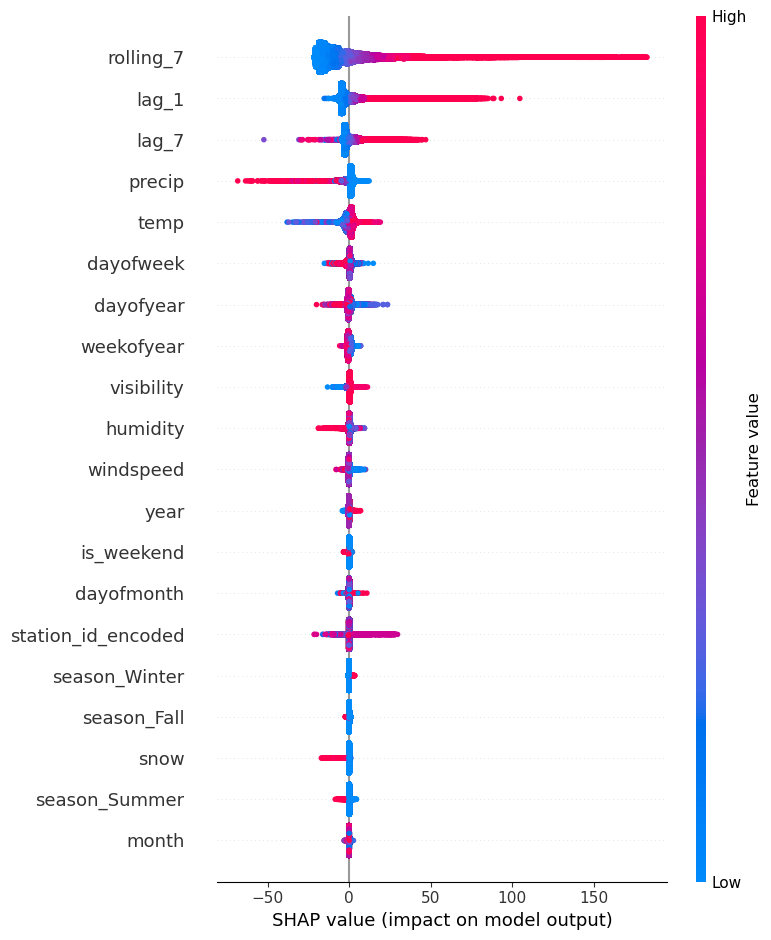

In [73]:
shap.summary_plot(shap_values, X_train)